# Longitudinal Analysis of ECAM dataset
This notebooks contains a re-analysis of the [ECAM dataset](http://stm.sciencemag.org/content/8/343/343ra82) using the q2-longitudinal plugin.

For more details, see the tutorials for this plugin at https://docs.qiime2.org/.

These commands were used to generate all results shown in Bokulich et al. (in review).

Commands run with version [qiime2-2018.8](https://docs.qiime2.org/2018.8/).

In [22]:
import os
import pandas as pd
import biom
import qiime2
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2.plugins import feature_table, longitudinal, diversity

%matplotlib inline

In [2]:
project_dir = os.path.expandvars('..')
data_dir = os.path.join(project_dir, 'data')
results_dir = os.path.join(project_dir, 'results')
sample_md = qiime2.Metadata.load(os.path.join(data_dir, 'ecam-sample-metadata.tsv'))

## Feature volatility

Initial assessment of the ECAM data focused on Bacteroides, due to prior interest of association of this genus with delivery mode. We will use q2-longitudinal to identify other age-predictive taxa and assess their association with sample groups.

In [7]:
%%bash
qiime longitudinal feature-volatility \
  --i-table ../data/ecam-table-genus.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-state-column month \
  --p-individual-id-column studyid \
  --p-n-jobs 4 \
  --p-n-estimators 100 \
  --output-dir ../results/feat-volatility-genus


Saved FeatureTable[RelativeFrequency] to: ../results/feat-volatility-genus/filtered_table.qza
Saved FeatureData[Importance] to: ../results/feat-volatility-genus/feature_importance.qza
Saved Visualization to: ../results/feat-volatility-genus/volatility_plot.qzv
Saved Visualization to: ../results/feat-volatility-genus/accuracy_results.qzv
Saved SampleEstimator[Regressor] to: ../results/feat-volatility-genus/sample_estimator.qza


This identifies several taxa that are predictive of age that appear to have different trajectories based on diet and delivery mode. Let us examine differences in these trajectories using LME.

In [32]:
# load table
table = qiime2.Artifact.load(os.path.join(data_dir, 'ecam-table-genus.qza'))
# split into "windows" to examine piecewise trajectories
# convert to relative abundances
t06, = feature_table.actions.filter_samples(table=table, metadata=sample_md, where="month<=6")
t06 = feature_table.actions.relative_frequency(t06).relative_frequency_table
t012, = feature_table.actions.filter_samples(table=table, metadata=sample_md, where="month<=12")
t012 = feature_table.actions.relative_frequency(t012).relative_frequency_table
t612, = feature_table.actions.filter_samples(table=table, metadata=sample_md, where="month>=6 AND month<=12")
t612 = feature_table.actions.relative_frequency(t612).relative_frequency_table
t618, = feature_table.actions.filter_samples(table=table, metadata=sample_md, where="month>=6 AND month<=18")
t618 = feature_table.actions.relative_frequency(t618).relative_frequency_table
t212, = feature_table.actions.filter_samples(table=table, metadata=sample_md, where="month>=2 AND month<=12")
t212 = feature_table.actions.relative_frequency(t212).relative_frequency_table


In [38]:
faecalibacterium = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium'
coprococcus = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus'
clostridium = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium'
bifidobacterium = 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium'

stuff_to_test = [(faecalibacterium, t612, '612'),
                 (coprococcus, t612, '612'),
                 (clostridium, t012, '012'),
                 (clostridium, t212, '212'),
                 (bifidobacterium, t06, '06'),
                 (bifidobacterium, t618, '618')]

In [ ]:
for target, tab, time in stuff_to_test:
    # extract the genus name for saving files
    target_name = target.split('__')[-1]
    # run LME
    viz, = longitudinal.actions.linear_mixed_effects(
        metadata=sample_md, metric=target, state_column='month', individual_id_column='studyid',
        group_columns='delivery,diet,sex', random_effects='month', table=tab)
    # save qzv
    viz.save(os.path.join(results_dir, 'feat-volatility-genus', 'lme-' + target_name + '-' + time + '.qzv'))

In [3]:
feature_md = qiime2.Metadata.load(
    os.path.join(results_dir, 'feat-volatility-genus', 'ecam-genus-FV-feature_metadata.tsv')).to_dataframe()
feature_md['importance'] = pd.to_numeric(feature_md['importance'])

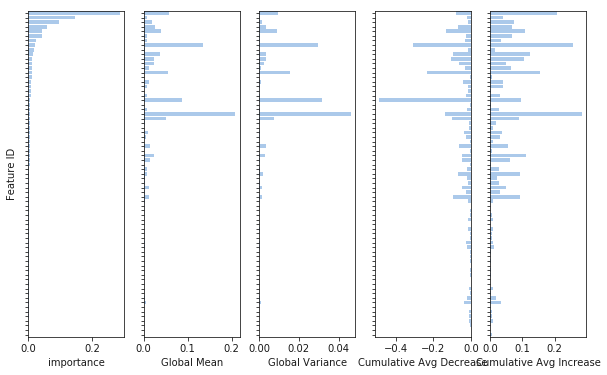

In [105]:
sns.set_color_codes("pastel")
f, axes = plt.subplots(1, 5, figsize=(10, 6))
for i, m in enumerate(['importance', 'Global Mean',
                       'Global Variance', 'Cumulative Avg Decrease',
                       'Cumulative Avg Increase']):
    g = sns.barplot(x=m, y=feature_md.index, data=feature_md, ax=axes[i], color='b')
    g.set(yticklabels=[])
    if i > 0:
        g.set(ylabel='')
    else:
        g.set(ylabel='Feature ID')


In [7]:
feature_md['importance'][:10].sum()

0.7528156433016181

## First distances

In [49]:
%%bash
qiime longitudinal first-distances \
  --i-distance-matrix ../data/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-state-column month \
  --o-first-distances ../results/first-distances.qza \
  --p-individual-id-column studyid \
  --p-replicate-handling random

# LME
qiime longitudinal linear-mixed-effects \
  --m-metadata-file ../results/first-distances.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-metric Distance \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/first-distances-LME.qzv \
  --p-group-columns delivery,diet,sex \
  --p-random-effects month

# volatility
qiime longitudinal volatility \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../results/first-distances.qza \
  --p-default-metric Distance \
  --p-default-group-column delivery \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/first-distances-volatility.qzv 


Saved SampleData[FirstDifferences] to: ../results/first-distances.qza
Saved Visualization to: ../results/first-distances-LME.qzv
Saved Visualization to: ../results/first-distances-volatility.qzv


test LME on segmented time frames

In [62]:
# load table
dm = qiime2.Artifact.load(os.path.join(data_dir, 'unweighted_unifrac_distance_matrix.qza'))
# split into "windows" to examine piecewise trajectories
# convert to relative abundances
d06, = diversity.actions.filter_distance_matrix(distance_matrix=dm, metadata=sample_md, where="month<=6")
d612, = diversity.actions.filter_distance_matrix(distance_matrix=dm, metadata=sample_md, where="month>=6 AND month<=12")
d618, = diversity.actions.filter_distance_matrix(distance_matrix=dm, metadata=sample_md, where="month>=6 AND month<=18")
d311, = diversity.actions.filter_distance_matrix(distance_matrix=dm, metadata=sample_md, where="month>=3 AND month<=11")


In [ ]:
for dm_sub, time in [(d06, 't06'), (d612, 't612'), (d311, 't311')]:
    # run LME
    fd, = longitudinal.actions.first_distances(
        distance_matrix=dm_sub, metadata=sample_md, state_column='month',
        individual_id_column='studyid', replicate_handling='random')
    viz, = longitudinal.actions.linear_mixed_effects(
        metadata=fd.view(qiime2.Metadata).merge(sample_md), metric='Distance', state_column='month',
        individual_id_column='studyid', group_columns='delivery,diet,sex', random_effects='month')
    # save qzv
    viz.save(os.path.join(results_dir, 'first-distances-LME-' + time + '.qzv'))

## Distance from baseline

In [51]:
%%bash
qiime longitudinal first-distances \
  --i-distance-matrix ../data/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-state-column month \
  --o-first-distances ../results/baseline-distances.qza \
  --p-individual-id-column studyid \
  --p-replicate-handling random \
  --p-baseline 0

# LME
qiime longitudinal linear-mixed-effects \
  --m-metadata-file ../results/baseline-distances.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-metric Distance \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/baseline-distances-LME.qzv \
  --p-group-columns delivery,diet,sex \
  --p-random-effects month

# volatility
qiime longitudinal volatility \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../results/baseline-distances.qza \
  --p-default-metric Distance \
  --p-default-group-column delivery \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/baseline-distances-volatility.qzv 


Saved SampleData[FirstDifferences] to: ../results/baseline-distances.qza
Saved Visualization to: ../results/baseline-distances-LME.qzv
Saved Visualization to: ../results/baseline-distances-volatility.qzv


In [ ]:
for dm_sub, time in [(d06, 't06')]:
    # run LME
    fd, = longitudinal.actions.first_distances(
        distance_matrix=dm_sub, metadata=sample_md, state_column='month',
        individual_id_column='studyid', replicate_handling='random', baseline=0)
    viz, = longitudinal.actions.linear_mixed_effects(
        metadata=fd.view(qiime2.Metadata).merge(sample_md), metric='Distance', state_column='month',
        individual_id_column='studyid', group_columns='delivery,diet,sex', random_effects='month')
    # save qzv
    viz.save(os.path.join(results_dir, 'baseline-distances-LME-' + time + '.qzv'))

## First distances shared species

In [16]:
%%bash
qiime feature-table rarefy \
   --i-table ../data/ecam-table-genus-mf7000-ms130.qza \
   --p-sampling-depth 2000 \
   --o-rarefied-table ../data/ecam-table-genus-mf7000-ms130-e2000.qza \

qiime diversity beta \
   --i-table ../data/ecam-table-genus-mf7000-ms130-e2000.qza \
   --p-metric 'jaccard' \
   --o-distance-matrix ../data/jaccard-distance-genera.qza

Saved FeatureTable[Frequency] to: ../data/ecam-table-genus-mf7000-ms130-e2000.qza
Saved DistanceMatrix to: ../data/jaccard-distance-genera.qza


In [17]:
%%bash
qiime longitudinal first-distances \
  --i-distance-matrix ../data/jaccard-distance-genera.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-state-column month \
  --o-first-distances ../results/first-distances-shared-genera.qza \
  --p-individual-id-column studyid \
  --p-replicate-handling random \

# LME
qiime longitudinal linear-mixed-effects \
  --m-metadata-file ../results/first-distances-shared-genera.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-metric Distance \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/first-distances-shared-genera-LME.qzv \
  --p-group-columns delivery,diet,sex \
  --p-random-effects month

# volatility
qiime longitudinal volatility \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../results/first-distances-shared-genera.qza \
  --p-default-metric Distance \
  --p-default-group-column delivery \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/first-distances-shared-genera-volatility.qzv 


Saved SampleData[FirstDifferences] to: ../results/first-distances-shared-genera.qza
Saved Visualization to: ../results/first-distances-shared-genera-LME.qzv
Saved Visualization to: ../results/first-distances-shared-genera-volatility.qzv


test LME on segmented time frames

In [60]:
# load table
dmj = qiime2.Artifact.load(os.path.join(data_dir, 'jaccard-distance-genera.qza'))
# split into "windows" to examine piecewise trajectories
# convert to relative abundances
dj03, = diversity.actions.filter_distance_matrix(distance_matrix=dmj, metadata=sample_md, where="month<=3")
dj312, = diversity.actions.filter_distance_matrix(distance_matrix=dmj, metadata=sample_md, where="month>=3 AND month<=12")
dj612, = diversity.actions.filter_distance_matrix(distance_matrix=dmj, metadata=sample_md, where="month>=6 AND month<=12")


In [ ]:
for dm_sub, time in [(dj03, 't03'), (dj312, 't312'), (dj612, 't612')]:
    # run LME
    fd, = longitudinal.actions.first_distances(
        distance_matrix=dm_sub, metadata=sample_md, state_column='month',
        individual_id_column='studyid', replicate_handling='random')
    viz, = longitudinal.actions.linear_mixed_effects(
        metadata=fd.view(qiime2.Metadata).merge(sample_md), metric='Distance', state_column='month',
        individual_id_column='studyid', group_columns='delivery,diet,sex', random_effects='month')
    # save qzv
    viz.save(os.path.join(results_dir, 'first-distances-shared-genera-LME-' + time + '.qzv'))

## Shared species with baseline

In [18]:
%%bash
qiime longitudinal first-distances \
  --i-distance-matrix ../data/jaccard-distance-genera.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-state-column month \
  --o-first-distances ../results/baseline-distances-shared-genera.qza \
  --p-individual-id-column studyid \
  --p-replicate-handling random \
  --p-baseline 0

# LME
qiime longitudinal linear-mixed-effects \
  --m-metadata-file ../results/baseline-distances-shared-genera.qza \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --p-metric Distance \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/baseline-distances-shared-genera-LME.qzv \
  --p-group-columns delivery,diet,sex \
  --p-random-effects month

# volatility
qiime longitudinal volatility \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../results/baseline-distances-shared-genera.qza \
  --p-default-metric Distance \
  --p-default-group-column delivery \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/baseline-distances-shared-genera-volatility.qzv 


Saved SampleData[FirstDifferences] to: ../results/baseline-distances-shared-genera.qza
Saved Visualization to: ../results/baseline-distances-shared-genera-LME.qzv
Saved Visualization to: ../results/baseline-distances-shared-genera-volatility.qzv


## Shared features with mother

In [19]:
%%bash
qiime feature-table rarefy \
   --i-table ../data/ecam-table-mothers.qza \
   --p-sampling-depth 2000 \
   --o-rarefied-table ../data/ecam-table-mothers-e2000.qza \

qiime diversity beta \
  --i-table ../data/ecam-table-mothers-e2000.qza \
  --p-metric 'jaccard' \
  --o-distance-matrix ../data/jaccard-distance-mothers.qza

Saved FeatureTable[Frequency] to: ../data/ecam-table-mothers-e2000.qza
Saved DistanceMatrix to: ../data/jaccard-distance-mothers.qza


In [20]:
%%bash
qiime longitudinal first-distances \
  --i-distance-matrix ../data/jaccard-distance-mothers.qza \
  --m-metadata-file ../data/ecam-mothers-metadata.tsv \
  --p-state-column month \
  --o-first-distances ../results/mothers-distances-shared-genera.qza \
  --p-individual-id-column studyid \
  --p-replicate-handling random \
  --p-baseline '-1'

Saved SampleData[FirstDifferences] to: ../results/mothers-distances-shared-genera.qza


In [21]:
%%bash
# LME
qiime longitudinal linear-mixed-effects \
  --m-metadata-file ../results/mothers-distances-shared-genera.qza \
  --m-metadata-file ../data/ecam-mothers-metadata.tsv \
  --p-metric Distance \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/mothers-distances-shared-genera-LME.qzv \
  --p-group-columns delivery,diet,sex \
  --p-random-effects month

# volatility
qiime longitudinal volatility \
  --m-metadata-file ../data/ecam-mothers-metadata.tsv \
  --m-metadata-file ../results/mothers-distances-shared-genera.qza \
  --p-default-metric Distance \
  --p-default-group-column delivery \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/mothers-distances-shared-genera-volatility.qzv 

Saved Visualization to: ../results/mothers-distances-shared-genera-LME.qzv
Saved Visualization to: ../results/mothers-distances-shared-genera-volatility.qzv


test LME on segmented time frames

In [43]:
mothers_md = qiime2.Metadata.load(os.path.join(data_dir, 'ecam-mothers-metadata.tsv'))

In [50]:
# load table
dm_mothers = qiime2.Artifact.load(os.path.join(data_dir, 'jaccard-distance-mothers.qza'))
# split into "windows" to examine piecewise trajectories
# convert to relative abundances
dm012, = diversity.actions.filter_distance_matrix(distance_matrix=dm_mothers, metadata=mothers_md, where="month<=12")


In [ ]:
for dm_sub, time in [(dm012, 't012')]:
    # run LME
    fd, = longitudinal.actions.first_distances(
        distance_matrix=dm_sub, metadata=mothers_md, state_column='month',
        individual_id_column='studyid', replicate_handling='random', baseline=-1)
    viz, = longitudinal.actions.linear_mixed_effects(
        metadata=fd.view(qiime2.Metadata).merge(mothers_md), metric='Distance', state_column='month',
        individual_id_column='studyid', group_columns='delivery,diet,sex', random_effects='month')
    # save qzv
    viz.save(os.path.join(results_dir, 'mothers-distances-shared-genera-LME-' + time + '.qzv'))

# Alpha diversity tests

In [67]:
%%bash
qiime longitudinal linear-mixed-effects \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../data/shannon.qza \
  --p-metric shannon \
  --p-group-columns delivery,diet,sex \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/shannon-linear-mixed-effects.qzv \
  --p-random-effects month

qiime longitudinal volatility \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../data/shannon.qza \
  --p-default-metric shannon \
  --p-default-group-column delivery \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/volatility.qzv \


Saved Visualization to: ../results/shannon-linear-mixed-effects.qzv
Saved Visualization to: ../results/volatility.qzv


## First differences

In [ ]:
%%bash
qiime longitudinal first-differences \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../data/shannon.qza \
  --p-state-column month \
  --p-metric shannon \
  --o-first-differences ../results/shannon-first-differences.qza \
  --p-individual-id-column studyid \
  --p-replicate-handling random

# volatility
qiime longitudinal volatility \
  --m-metadata-file ../data/ecam-sample-metadata.tsv \
  --m-metadata-file ../results/examples/shannon-first-differences.qza \
  --p-default-metric Difference \
  --p-default-group-column delivery \
  --p-state-column month \
  --p-individual-id-column studyid \
  --o-visualization ../results/shannon-first-differences-volatility.qzv \
